# Setup

In [40]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [41]:
%matplotlib inline

In [42]:
import sys
sys.path.append('/home/imendoza/nbody-relaxed/')

import relaxed

In [43]:
from relaxed.plot_defaults import *

In [44]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import sklearn
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [1]:
from relaxed.analysis import get_mah, add_box_indices, alpha_analysis, vol_jacknife_err, get_an_from_am, get_a_from_t, get_t_from_a, diffmah_analysis
from relaxed.models import training_suite, prepare_datasets
from relaxed import halo_catalogs


# Data

In [59]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [60]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
eta = cat['eta']
spin = cat['spin']
voff = cat['v0']
# spin_b = cat['spin_bullock'] # need to add catalog 
# m2 = cat['m2_a179'], fraction of largest subhalo mass 
# separate b/a and c/a ?? 
q = cat['q']
ma = mah_data['ma']
ma_peak = mah_data['ma_peak']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [61]:
# extract m(a_{tdyn}) = \dot{M}_dynamical
from astropy import units as u
t0 = get_t_from_a(1)
tdyn = np.mean(cat['tdyn']) / 10**9
t = (t0 - tdyn) * u.Gyr
a_dyn = get_a_from_t(t)
indx_dyn = np.where(scales>0.805)[0][0]
mdyn = ma[:, indx_dyn].reshape(-1, 1)

In [49]:
alphas, ma_exp, am_exp = alpha_analysis(ma, scales, mass_bins)

Fitting Alpha parametrization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 142.00it/s]


In [62]:
a2 = get_an_from_am(am, mass_bins, mbin=0.5)
a4 = get_an_from_am(am, mass_bins, mbin=0.75)

In [63]:
# # hearin parameters.
# tau_c, alpha_early, alpha_late = diffmah_analysis(ma_peak, scales,)
# keep_diffmah = ~np.isnan(tau_c)

In [64]:
cat.add_column(alphas, name='alpha') # use log scale. -> nan's?
cat.add_column(a2, name='a2') #use log scale
cat.add_column(a4, name='a4') # use log scale.
cat.add_column(mdyn, name='mdyn') # no need to log scale 
# cat.add_column(tau_c, name='tau_c') # -> use log scale.
# cat.add_column(alpha_early, name='alpha_early')
# cat.add_column(alpha_late, name='alpha_late')
# cat = cat[keep_diffmah] # filter out nan diffmah parameters.

In [65]:
#finally diffmah jax fits.
from diffmah.individual_halo_assembly import _get_early_late
pars = np.load('../../output/pbest_9900.npy')
logtc, ue, ul = pars[:, 0], pars[:, 1], pars[:, 2]
early, late = _get_early_late(ue, ul)

cat = cat[:9901]
cat.add_column(10**logtc, name='tau_c') # -> use log scale.
cat.add_column(early, name='alpha_early')
cat.add_column(late, name='alpha_late')

In [66]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [67]:
info = {
    'cvir_only': {'x': ('cvir', ), 'y': ('a2', 'a4', 'mdyn', 'alpha', 'tau_c', 'alpha_early', 'alpha_late' ), },
    'x0_only': {'x': ('x0', ), 'y': ('a2', 'a4', 'mdyn', 'alpha','tau_c', 'alpha_early', 'alpha_late'), },
    'all': {'x':('cvir', 't/|u|', 'x0', 'spin', 'q'), 'y':('a2', 'a4', 'mdyn', 'alpha','tau_c', 'alpha_early', 'alpha_late'),},
    'except_cvir': {'x':('t/|u|', 'x0', 'spin', 'q'), 'y':('a2', 'a4', 'mdyn', 'alpha','tau_c', 'alpha_early', 'alpha_late'),},
    'except_x0': {'x':('cvir', 't/|u|', 'spin', 'q'), 'y':('a2', 'a4', 'mdyn', 'alpha','tau_c', 'alpha_early', 'alpha_late'),},
}
datasets, cat_train, cat_test = prepare_datasets(cat, info)

# Train

In [68]:
# joint models
data ={
    'linear_cvir': {
        'xy': datasets['cvir_only']['train'], 'n_features': 1, 'n_targets': 7, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_x0': {
        'xy': datasets['x0_only']['train'], 'n_features': 1, 'n_targets': 7, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_all': {
        'xy': datasets['all']['train'], 'n_features': 5, 'n_targets': 7, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_except_cvir': {
        'xy': datasets['except_cvir']['train'], 'n_features': 4, 'n_targets': 7, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'linear_except_x0': {
        'xy': datasets['except_x0']['train'], 'n_features': 4, 'n_targets': 7, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
joint_models = training_suite(data)


# Metrics whisker plots

## Setup

In [69]:
latex_metrics = {
    'mu': r"$\mu \left( y_{\rm pred} - y_{\rm true} \right)$", 
    'med': r"$\mu_{x}'$",
    'sigma_ratio': r"$\sigma_{\rm pred} / \sigma_{\rm true}$",
    'spear': r"$\rho_{\rm spearman}$",
    'rscatter':r"$\frac{\sigma(y_{\rm pred} - y_{\rm true})}{ \sigma(y_{\rm true}) \sqrt{2}}$",
    'mad': r"\rm MAD",
}

latex_params = {
    'cvir': r"$c_{\rm vir}$",
    't/|u|':  r"$t/\vert u \vert$",
    'x0': r"$x_{\rm off}$", 
    'spin': r"$s$",
    'q': r"$q$",
    'a2': r"$a_{1/2}$",
    'alpha': r"$\alpha$", 
    'a4': r"$a_{3/4}$",
    'mdyn': r"$m(a_{\rm dyn})$",
    'tau_c': r"$\tau_{c}$",
    'alpha_early': r"$\alpha_{\rm early}$",
    'alpha_late': r"$\alpha_{\rm late}$",
}


def compute_metrics(pred_func, _x_test, _y_test, box_keep = None):
    # pred_func should return ONLY 1 parameter. (e.g. lambda wrapped around indexing)
    if box_keep is None:
        box_keep = np.ones(_x_test.shape[0]).astype(bool)
    
    x_test = _x_test[box_keep]
    y_test = _y_test[box_keep].reshape(-1)
    
    y_pred = pred_func(x_test).reshape(-1)
    x = (y_pred - y_test) / np.std(y_test) # normalize

    return {'mu': np.mean(x), 
            'sigma_ratio': np.std(y_pred) / np.std(y_test), 
            'spear': scipy.stats.spearmanr(y_pred, y_test)[0],
            'rscatter': np.std(x) / np.sqrt(2), 
            'mad': np.mean(np.abs(x)), 
           }


def metrics_plot(metrics_data: dict, test_data: dict, trained_models: dict, 
                 cat_test, params=("cvir",), legend_size=20, figsize=(12, 12),nrows=2, ncols=2,
                 ticksize=16,
               ):
    # params and models MUST have same order (until switch to pandas...)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    model_metrics = {} 

    for jj, param in enumerate(params): 
        for mdl_name, (x_test, label, color, shape) in test_data.items():
            model = trained_models[mdl_name]
            pred_func = lambda x: model.predict(x)[:, jj]
            y_test = cat_test[param].value.reshape(-1)
            y_pred = pred_func(x_test).reshape(-1)
            x = (y_pred - y_test) / np.std(y_test)
            val_metrics = compute_metrics(pred_func, x_test, y_test)
            errs = vol_jacknife_err(cat_test, compute_metrics, pred_func, x_test, y_test, mode='dict')
            model_metrics[(param, mdl_name)] = {k:(val_metrics[k], errs[k]) for k in metrics_data}

    params_latex = [latex_params[par] for par in params]
    for ii, met in enumerate(metrics_data):
        ax = axes[ii]
        ax.set_xlim(-0.25, len(params))
        if 'yrange' in metrics_data[met]:
            if metrics_data[met]['yrange'] is not None:
                ax.set_ylim(metrics_data[met]['yrange'])
        ax.set_xticks(np.array(list(range(len(params)))))
        ax.set_xticklabels(params_latex)
        ax.tick_params(axis='x', labelsize=ticksize)
        x_bias = 0.0
        for kk, (mdl_name, (x_test, label, color, marker)) in enumerate(test_data.items()):
            for jj, param in enumerate(params):
                label = label if (jj== 0 and ii==0) else None
                val, err = model_metrics[(param, mdl_name)][met]
                ax.errorbar(jj+x_bias, val, yerr=err, label=label, marker=marker, 
                            color=color, capsize=2.5, ms=6, capthick=2.0)
            x_bias+=0.1
        
        if metrics_data[met].get('hline', None) is not None:
            ax.axhline(metrics_data[met]['hline'], ls='--', color='k')
        ax.set_ylabel(latex_metrics[met], size=28)
        
        if ii == 0:
            ax.legend(prop={'size':legend_size}, bbox_to_anchor=(0.85, 1.35))
    plt.tight_layout()

## Results

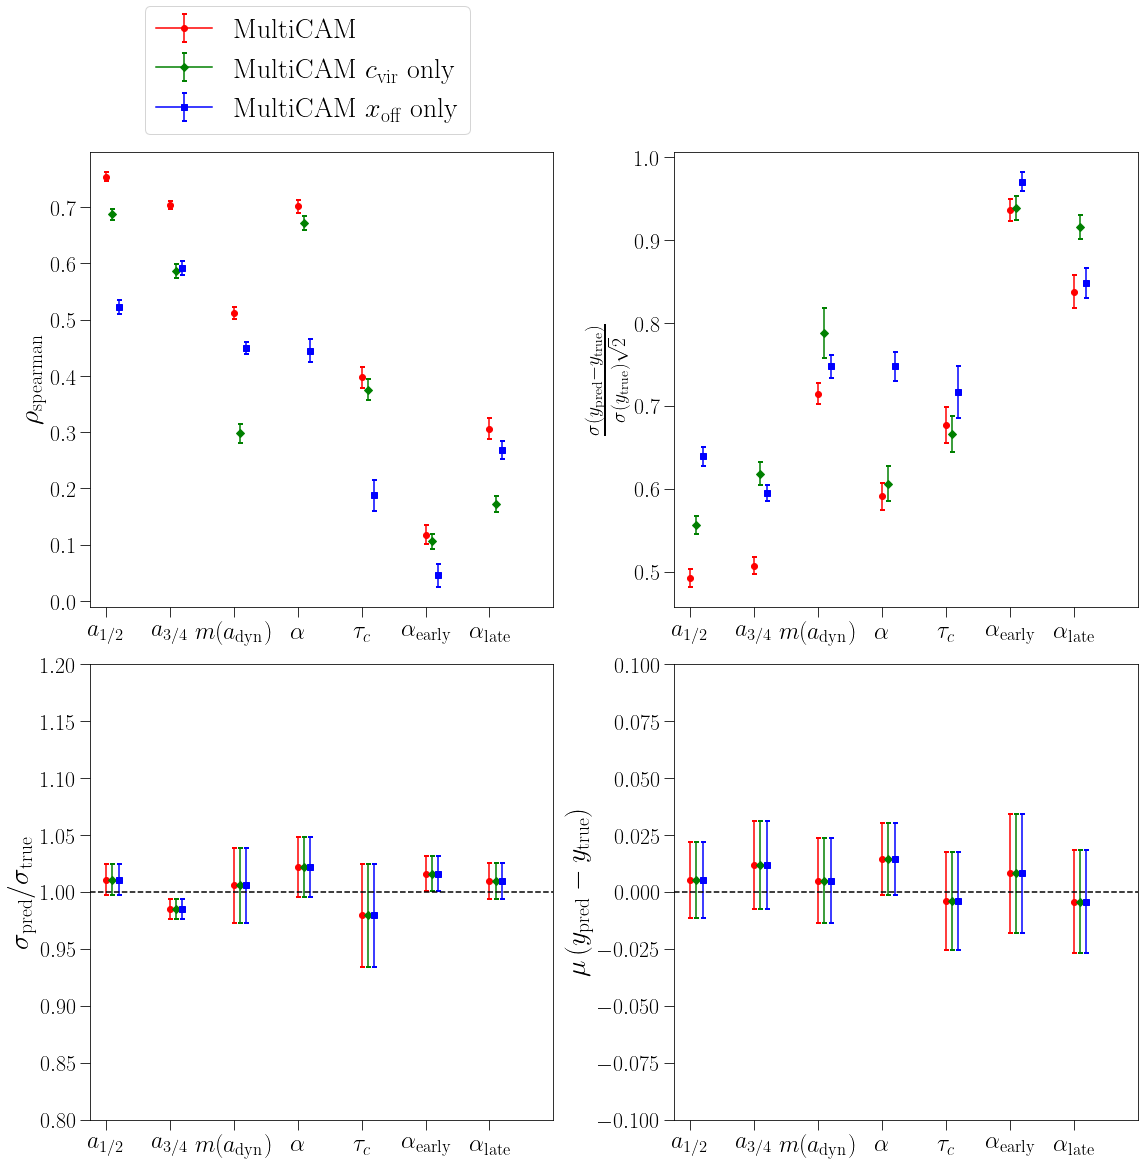

In [70]:
metrics_data = {
    'spear': {},
    'rscatter': {},
    'sigma_ratio': {'yrange':(0.8, 1.2), 'hline': 1.0},
    'mu': {'yrange':(-0.1, 0.1), 'hline': 0.0},
}
test_data = {
    'linear_all': (datasets['all']['test'][0], r"\rm MultiCAM", 'r', 'o'),
    'linear_cvir': (datasets['cvir_only']['test'][0], r"\rm MultiCAM $c_{\rm vir}$ only", 'g', 'D'),
    'linear_x0': (datasets['x0_only']['test'][0], r"\rm MultiCAM $x_{\rm off}$ only", 'b', 's'),
#     'linear_except_cvir': (datasets['except_cvir']['test'][0], r"\rm Linear Regression except $c_{\rm vir}$", 'g', '^'),
#     'linear_except_x0': (datasets['except_x0']['test'][0], r"\rm Linear Regression except $x_{\rm off}$", 'c', '*'),

}
metrics_plot(metrics_data, test_data, joint_models, cat_test, params=('a2', 'a4', 'mdyn', 'alpha', 'tau_c', 'alpha_early', 'alpha_late'), 
             ncols=2, nrows=2, figsize=(16, 16), ticksize=24, legend_size=28)

